In [5]:
import torch
import torch.backends.cudnn as cudnn
import torchvision
import cv2 
from matplotlib import pyplot as plt
import os,glob,sys
from tqdm import tqdm
import numpy as np
import PIL
import random
from PIL import Image
import h5py
from typing import Generator
import gc,json 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0"  # Set the GPU 1 to use
from core.data_loader import sem_generator,patch_generator, load_whole_image
from core.crop_image import scale_f_num_0to3,crop_image, make_image_crop
from core.utils import seed_everything
from core.patch_generate import *

In [6]:
seed_everything(0) # Seed 고정

In [8]:
# load whole image[size : (2048, 3072)] in "whole_images" 
data_path = "Samsung+SNU+dataset+221115" #"Samsung_SNU"
num_per_Ffolder = 2#16
# whole_images = load_whole_image(data_path,num_per_Ffolder)

In [9]:
def generate_top_bottom_crop_image(data_path : str,generator : Generator[str,str,np.array],save=True):
    for img in generator:
        print(img[:3])
        set_num, f_num, image_num = img[:3]
        save_dir = os.path.join(data_path+"_1536x3072",set_num)
        os.makedirs(save_dir,exist_ok=True)
        #print(save_dir)
    
        img = img[-1][256:-256,:]
        #print(img.shape) # (1536, 3072)
        #plt.imshow(img,cmap='gray')
        file_name = f"{f_num}_{image_num}.png"
        file_path = os.path.join(save_dir,file_name)
        if save is True:
            cv2.imwrite(file_path,img)

In [10]:
# crop top_bottom image

In [14]:

#!rm -r ./Samsung_SNU_1536x3072/*
#!ls ./Samsung_SNU_1536x3072

gen = sem_generator(data_path)
generate_top_bottom_crop_image(data_path,gen)

['SET0', 'F1', '1']
['SET0', 'F1', '2']
['SET0', 'F16', '1']
['SET0', 'F16', '2']
['SET0', 'F2', '1']
['SET0', 'F2', '2']
['SET0', 'F32', '1']
['SET0', 'F32', '2']
['SET0', 'F4', '1']
['SET0', 'F4', '2']
['SET0', 'F64', '1']
['SET0', 'F64', '2']
['SET0', 'F8', '1']
['SET0', 'F8', '2']
['SET5', 'F1', '1']
['SET5', 'F1', '2']
['SET5', 'F16', '1']
['SET5', 'F16', '2']
['SET5', 'F2', '1']
['SET5', 'F2', '2']
['SET5', 'F32', '1']
['SET5', 'F32', '2']
['SET5', 'F4', '1']
['SET5', 'F4', '2']
['SET5', 'F64', '1']
['SET5', 'F64', '2']
['SET5', 'F8', '1']
['SET5', 'F8', '2']
['SET6', 'F1', '1']
['SET6', 'F1', '2']
['SET6', 'F16', '1']
['SET6', 'F16', '2']
['SET6', 'F2', '1']
['SET6', 'F2', '2']
['SET6', 'F32', '1']
['SET6', 'F32', '2']
['SET6', 'F4', '1']
['SET6', 'F4', '2']
['SET6', 'F64', '1']
['SET6', 'F64', '2']
['SET6', 'F8', '1']
['SET6', 'F8', '2']
['SET7', 'F1', '1']
['SET7', 'F1', '2']
['SET7', 'F16', '1']
['SET7', 'F16', '2']
['SET7', 'F2', '1']
['SET7', 'F2', '2']
['SET7', 'F32', '1']

In [28]:
!ls Samsung_SNU_1536x3072/SET1/F16_1.png

Samsung_SNU_1536x3072/SET1/F16_1.png


In [15]:
!tree Samsung_SNU_1536x3072 | tail -n 1
!tree Samsung_SNU_1536x3072/SET1 | tail -n 1
!tree Samsung_SNU_1536x3072/SET2 | tail -n 1
!tree Samsung_SNU_1536x3072/SET3 | tail -n 1
!tree Samsung_SNU_1536x3072/SET4 | tail -n 1
"""
expected output
4 directories, 256 files
0 directories, 64 files
0 directories, 64 files
0 directories, 64 files
0 directories, 64 files
"""

4 directories, 256 files
0 directories, 64 files
0 directories, 64 files
0 directories, 64 files
0 directories, 64 files


'\nexpected output\n4 directories, 256 files\n0 directories, 64 files\n0 directories, 64 files\n0 directories, 64 files\n0 directories, 64 files\n'

In [19]:
!tree Samsung+SNU+dataset+221115_1536x3072 | tail -n 1
!tree Samsung+SNU+dataset+221115_1536x3072/SET10 | tail -n 1
!tree Samsung+SNU+dataset+221115_1536x3072/SET5 | tail -n 1
!tree Samsung+SNU+dataset+221115_1536x3072/SET6 | tail -n 1
!tree Samsung+SNU+dataset+221115_1536x3072/SET7 | tail -n 1
!tree Samsung+SNU+dataset+221115_1536x3072/SET8 | tail -n 1
!tree Samsung+SNU+dataset+221115_1536x3072/SET9 | tail -n 1


6 directories, 84 files
0 directories, 14 files
0 directories, 14 files
0 directories, 14 files
0 directories, 14 files
0 directories, 14 files
0 directories, 14 files


In [ ]:
# below related to making patch

In [25]:
data_path="Samsung+SNU+dataset+221115_1536x3072"#"./Samsung_SNU_1536x3072"
crop_data_path="Samsung+SNU+dataset+221115_1536x3072_cropped" #"./Samsung_SNU_cropped"
os.makedirs(crop_data_path,exist_ok=True)
#random_crop = torchvision.transforms.RandomCrop(size=256)
crop_size = 256
num_crop= 500

In [33]:
## make align information
# per set, takes 12 min
#data_path="./Samsung_SNU_1536x3072"
shift_info = {}
show_log = True
for device_id,set_num in enumerate(sorted(os.listdir(data_path))):
    print(set_num)
    shift_info[f"{set_num}"] = {}

    set_path = os.path.join(data_path,set_num)
    noisy_f_num = ['F1','F2','F4','F8','F16','F32']
    
    for i,f_num in enumerate(noisy_f_num): # f_num 마다 구분
        for image_idx, image_path in tqdm(enumerate(sorted(glob.glob(f"{set_path}/{f_num}*.png")))):
            #print(image_path)
            image_num = image_path.split("_")[-1]
            clean_path = os.path.join(data_path,set_num,f"F64_{image_num}")
            if show_log is True : 
                print(image_path, clean_path)
            
            im = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
            target_im = cv2.imread(clean_path,cv2.IMREAD_GRAYSCALE)
            
            v_shift, h_shift = get_shift_info(im, target_im,v_width=40,h_width=40)
            shift_info[set_num][image_path] = {'v_shift' : v_shift, 'h_shift' : h_shift}
            if show_log is True:
                print( v_shift,h_shift)
    
with open(f'shift_info_5~10.txt', 'w') as f:
    f.write(json.dumps(shift_info,indent="\t"))
print(f"write to shift_info_5~10txt complete")
    """

SET10


0it [00:00, ?it/s]

Samsung+SNU+dataset+221115_1536x3072/SET10/F16_1.png Samsung+SNU+dataset+221115_1536x3072/SET10/F64_1.png


1it [00:24, 24.02s/it]

0 -25
Samsung+SNU+dataset+221115_1536x3072/SET10/F16_2.png Samsung+SNU+dataset+221115_1536x3072/SET10/F64_2.png


2it [00:48, 24.11s/it]

9 -24
Samsung+SNU+dataset+221115_1536x3072/SET10/F1_1.png Samsung+SNU+dataset+221115_1536x3072/SET10/F64_1.png


3it [01:12, 24.35s/it]

-5 -32
Samsung+SNU+dataset+221115_1536x3072/SET10/F1_2.png Samsung+SNU+dataset+221115_1536x3072/SET10/F64_2.png


3it [01:17, 25.71s/it]


KeyboardInterrupt: 

In [31]:
shift_info

{'SET10': {'Samsung+SNU+dataset+221115_1536x3072/SET10/F16_1.png': {'v_shift': 0,
   'h_shift': -25},
  'Samsung+SNU+dataset+221115_1536x3072/SET10/F16_2.png': {'v_shift': 9,
   'h_shift': -24},
  'Samsung+SNU+dataset+221115_1536x3072/SET10/F1_1.png': {'v_shift': -4,
   'h_shift': -30},
  'Samsung+SNU+dataset+221115_1536x3072/SET10/F1_2.png': {'v_shift': 13,
   'h_shift': -30}}}

In [ ]:
!rm -r ./Samsung_SNU_1474x3010_aligned
!ls ./Samsung_SNU_1474x3010_aligned

data_path="./Samsung_SNU_1536x3072"
aligned_data_path="./Samsung_SNU_1474x3010_aligned"
os.makedirs(aligned_data_path,exist_ok=True)

pad = 31
import json
for set_num in sorted(os.listdir(data_path)):
    print(f"====== {set_num}======")
    shift_info = {}
    with open(f"shift_info_{set_num[-1]}.txt",'r') as f:
        shift_info = json.load(f)
        #print(shift_info[set_num].keys())
    set_path = os.path.join(data_path,set_num)
    aligned_set_path = os.path.join(aligned_data_path,set_num)
    os.makedirs(aligned_set_path,exist_ok=True)
    shift_info = shift_info[set_num]
    #print(shift_info[set_path+"/F8_14.png"])
    for file_name in sorted(os.listdir(set_path)):
        if "checkpoints" in file_name :
            continue
        img_path = os.path.join(set_path,file_name)
        save_path = os.path.join(aligned_data_path,set_num,file_name)
        img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
        
        print(f"{file_name} save path : {save_path}")
        if "F64" in file_name :
            padded_img = img[pad:-pad,pad:-pad]
            assert padded_img.shape == (1474,3010)
            cv2.imwrite(save_path,padded_img)
            print(file_name, padded_img.shape)
            continue
        file_path = os.path.join(set_path,file_name)
        v_shift, h_shift = shift_info[file_path].values()
        file_num = file_name.split("_")[-1].split(".")[0]
        padded_img = img[pad+v_shift:-pad+v_shift:,pad+h_shift:-pad+h_shift]
        assert padded_img.shape == (1474,3010)
        print(file_name,v_shift, h_shift,padded_img.shape)
        #print(shift_info[file_path])
        # plt.imshow(clean_img,cmap='gray')
        cv2.imwrite(save_path,padded_img)
        
        #break
        
    #break
print("complete align")

# deal with MSE metric

In [5]:
shift_info = {}
with open(f"shift_info_4.txt",'r') as f:
    shift_info = json.load(f)
f8_8 = cv2.imread('./Samsung_SNU_1474x3010_aligned/SET1/F8_8.png',cv2.IMREAD_GRAYSCALE)
f8_8_before = cv2.imread('./Samsung_SNU_1536x3072/SET1/F8_8.png',cv2.IMREAD_GRAYSCALE)
f64_8 = cv2.imread('./Samsung_SNU_1474x3010_aligned/SET1/F64_8.png',cv2.IMREAD_GRAYSCALE)
f64_8_before = cv2.imread('./Samsung_SNU_1536x3072/SET1/F64_8.png',cv2.IMREAD_GRAYSCALE)
shift_info['SET1']['./Samsung_SNU_1536x3072/SET1/F8_8.png']

{'v_shift': 6, 'h_shift': -19}

In [28]:
def mse(img1,img2):
    return np.average(np.sqrt(np.square(img1 - img2)))

In [16]:
import torch
mse = torch.nn.MSELoss()
print(f8_8.shape, f64_8.shape)
np.average(np.sqrt(np.square(f8_8 - f64_8))), np.average(np.sqrt(np.square(f8_8_before - f64_8_before)))

(1474, 3010) (1474, 3010)


(9.086, 9.15)

In [32]:
v_shift, h_shift = get_shift_info(f8_8_before, f64_8_before,log=True)

original ssim (whole) : 0.034743512874180385, psnr : 14.225812471549528
original ssim (patch): 0.030568992911273893, psnr : 14.242794156031104
{'ssim': 0.09399695923798351, 'psnr': 15.786449470024746, 'v_shift': 6, 'h_shift': -20}
{'ssim': 0.09213567036602474, 'psnr': 15.818983072833602, 'v_shift': 6, 'h_shift': -19}


In [33]:
shift_info['SET1']['./Samsung_SNU_1536x3072/SET1/F8_8.png']

{'v_shift': 6, 'h_shift': -19}

(1474, 0)


/tmp/ipykernel_25732/1935720538.py:27: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(im[top:top+crop_size,left:left+crop_size],cmap='gray')


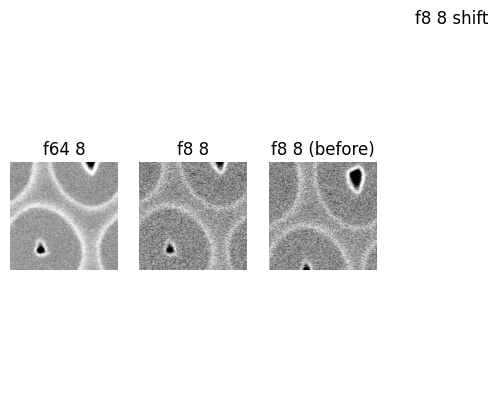

In [34]:
pad = 31
top = 100
left = 100
crop_size = 200

plt.subplot(1,4,1)
plt.axis('off')
plt.title('f64 8')
plt.imshow(f64_8[top:top+crop_size,left:left+crop_size],cmap='gray')
plt.subplot(1,4,2)
plt.axis('off')
plt.title('f8 8')
plt.imshow(f8_8[top:top+crop_size,left:left+crop_size],cmap='gray')
plt.subplot(1,4,3)
plt.axis('off')
plt.title('f8 8 (before)')
plt.imshow(f8_8_before[top:top+crop_size,left:left+crop_size],cmap='gray')
plt.subplot(1,4,4)
plt.axis('off')
plt.title('f8 8 shift')
v_shift += shift_info['SET1']['./Samsung_SNU_1536x3072/SET1/F8_8.png']['v_shift']
h_shift += shift_info['SET1']['./Samsung_SNU_1536x3072/SET1/F8_8.png']['h_shift']
#top += v_shift
#left += h_shift
im = f8_8_before[pad+v_shift:-pad+v_shift,pad+h_shift:-pad+h_shift]
print(im.shape)
plt.imshow(im[top:top+crop_size,left:left+crop_size],cmap='gray')

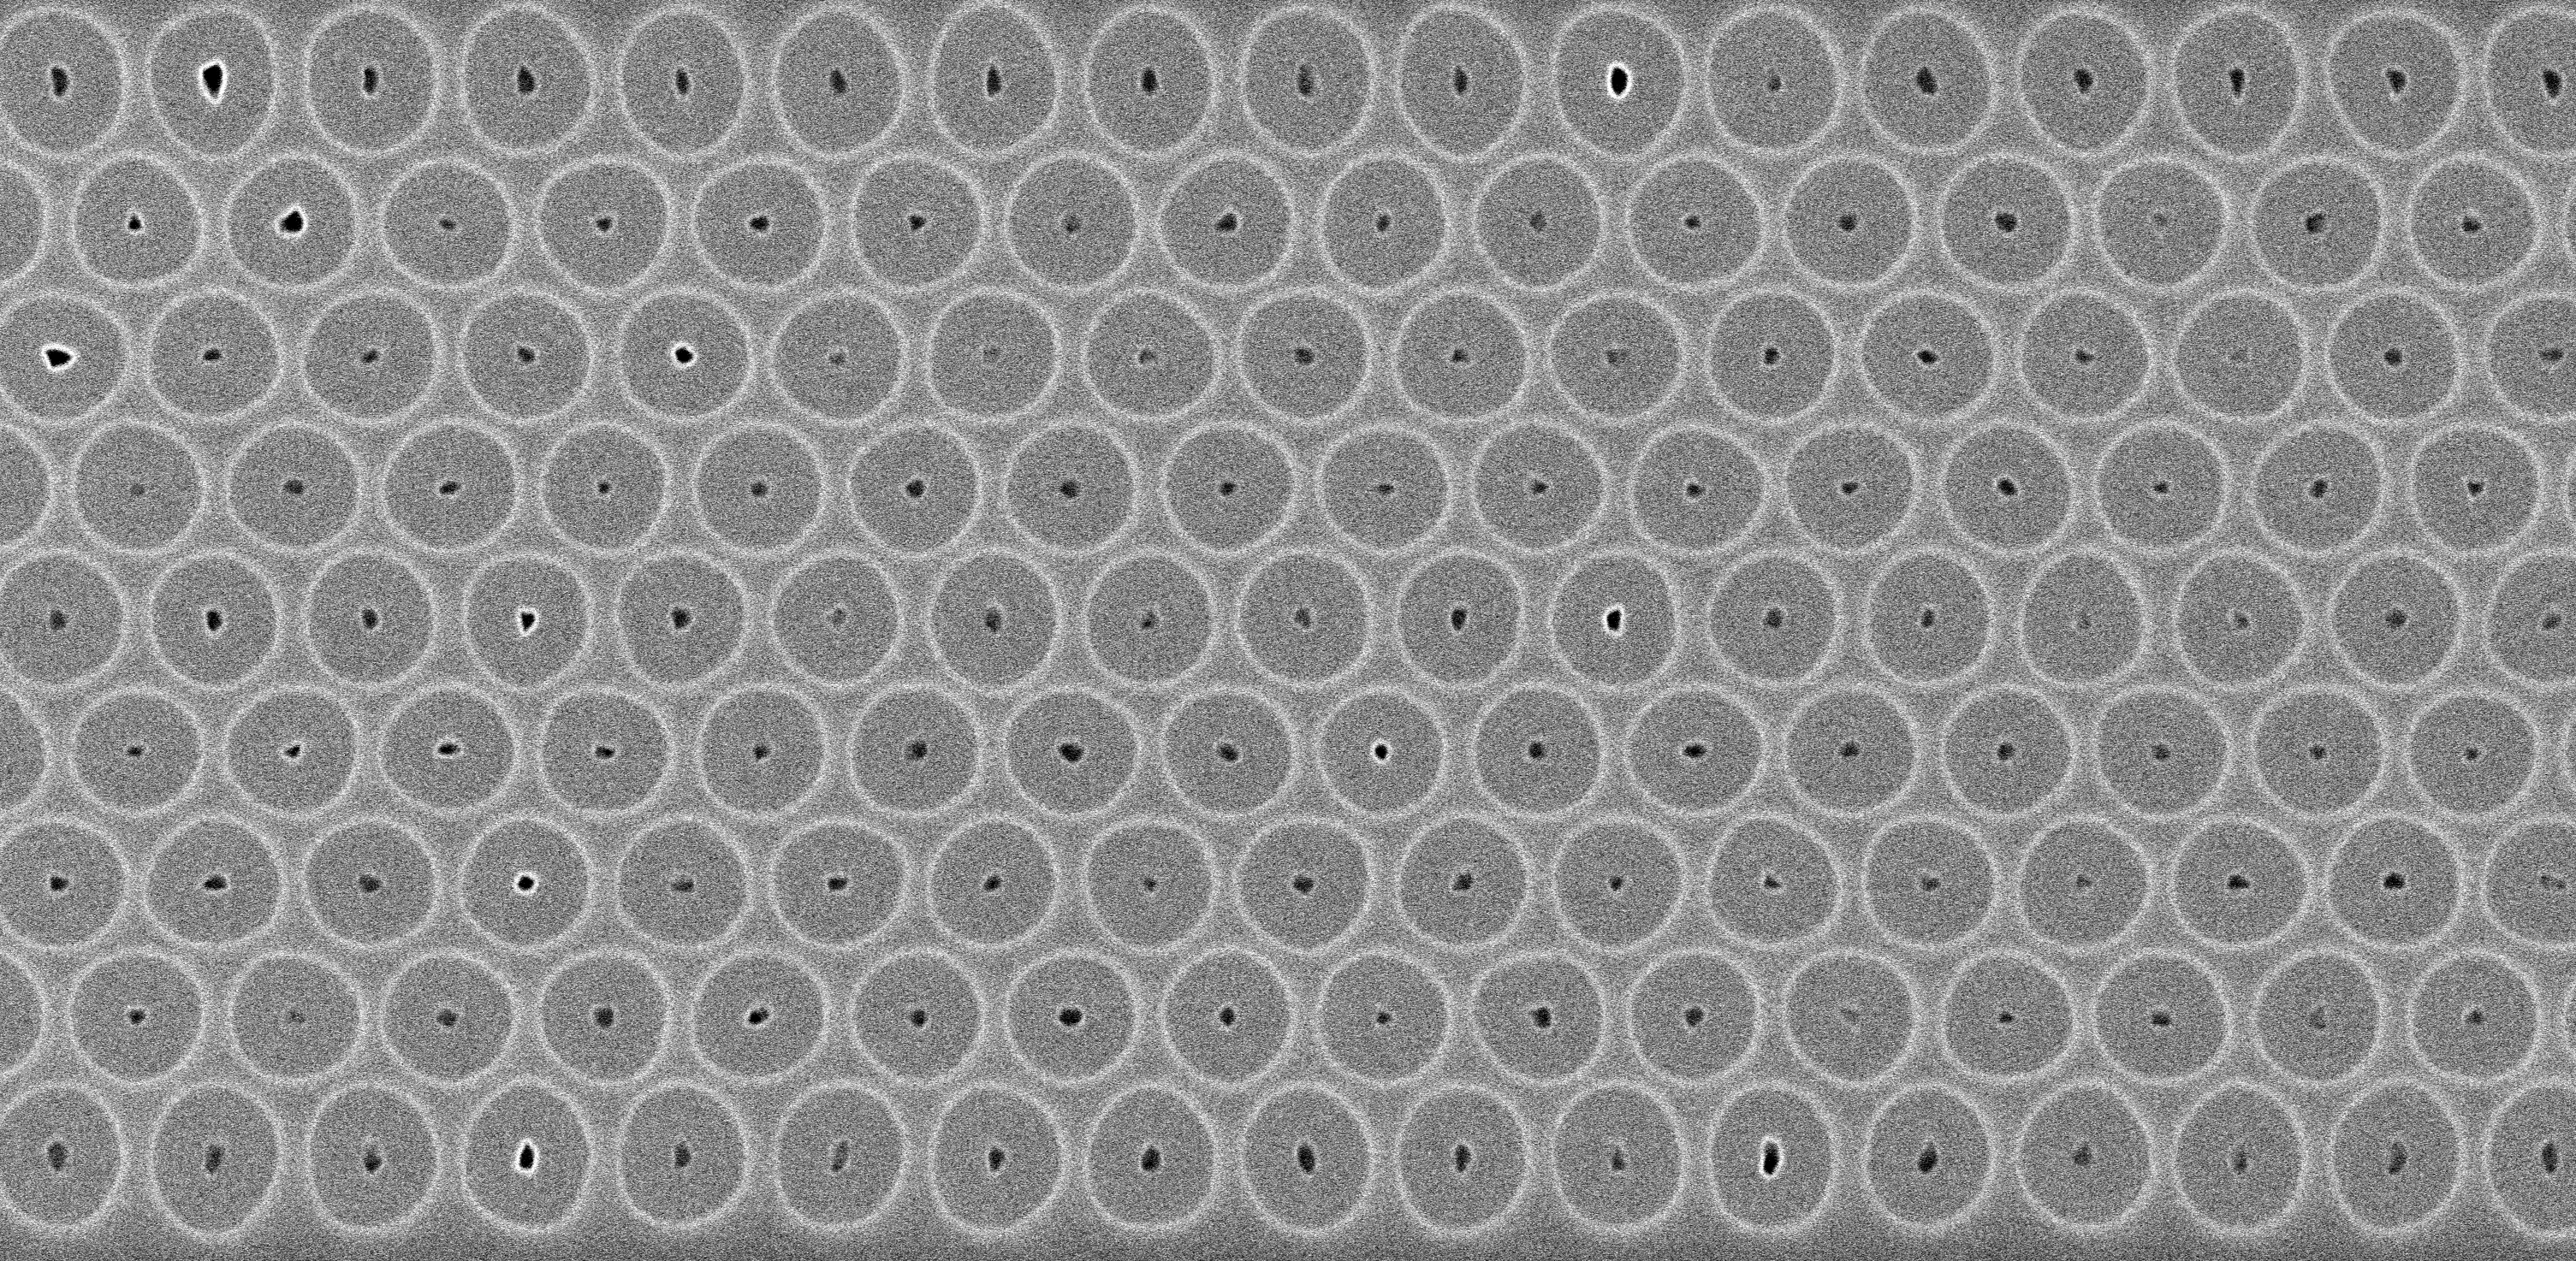

In [35]:
PIL.Image.fromarray(f8_8)

In [36]:
PIL.Image.fromarray(f64_8[-v_shift:,h_shift:])

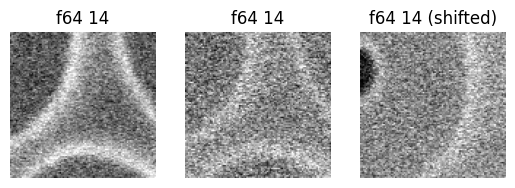

In [37]:

top = 100
left = 100
crop_size = 100

plt.subplot(1,3,1)
plt.axis('off')
plt.title('f64 14')
plt.imshow(f64_8[top:top+crop_size,left:left+crop_size],cmap='gray')
plt.subplot(1,3,2)
plt.axis('off')
plt.title('f64 14')
plt.imshow(f8_8[top:top+crop_size,left:left+crop_size],cmap='gray')
plt.subplot(1,3,3)
plt.axis('off')
plt.title('f64 14 (shifted)')
top += shift_info['SET1']['./Samsung_SNU_1536x3072/SET1/F8_8.png']['v_shift']
left += shift_info['SET1']['./Samsung_SNU_1536x3072/SET1/F8_8.png']['h_shift']
plt.imshow(f8_8_before[top:top+crop_size,left:left+crop_size],cmap='gray')

In [38]:
whole_images?

Object `whole_images` not found.


## check pixel difference by MSE 

In [21]:
whole_images = load_whole_image(data_path,num_per_Ffolder)

=== extracting [SET 1] ===
Samsung_SNU/[SET 1]/F32
Samsung_SNU/[SET 1]/F8
Samsung_SNU/[SET 1]/F64
Samsung_SNU/[SET 1]/F16
=== extracting [SET 2] ===
Samsung_SNU/[SET 2]/F32
Samsung_SNU/[SET 2]/F8
Samsung_SNU/[SET 2]/F64
Samsung_SNU/[SET 2]/F16
=== extracting [SET 3] ===
Samsung_SNU/[SET 3]/F32
Samsung_SNU/[SET 3]/F8
Samsung_SNU/[SET 3]/F64
Samsung_SNU/[SET 3]/F16
=== extracting [SET 4] ===
Samsung_SNU/[SET 4]/F32
Samsung_SNU/[SET 4]/F8
Samsung_SNU/[SET 4]/F64
Samsung_SNU/[SET 4]/F16


In [22]:
whole_images?

Type:        dict
String form:
{'[SET 1]': {'F32': {'1_F32.png': array([[120, 141, 111, ..., 101, 122,  98],
           [119, 126, 1 <...> [114,  85,  94, ..., 128,  86,  50],
           [141, 107, 117, ...,  89,  90, 104]], dtype=uint8)}}}
Length:      4
Docstring:  
dict() -> new empty dictionary
dict(mapping) -> new dictionary initialized from a mapping object's
    (key, value) pairs
dict(iterable) -> new dictionary initialized as if via:
    d = {}
    for k, v in iterable:
        d[k] = v
dict(**kwargs) -> new dictionary initialized with the name=value pairs
    in the keyword argument list.  For example:  dict(one=1, two=2)


In [23]:
gt = whole_images['[SET 1]']['F64']['8_F64.png']
noisy = whole_images['[SET 1]']['F8']['8_F8.png'] 
"""
		"./Samsung_SNU_1536x3072/SET1/F8_8.png": {
			"v_shift": 6,
			"h_shift": -19
		},
"""

'\n\t\t"./Samsung_SNU_1536x3072/SET1/F8_8.png": {\n\t\t\t"v_shift": 6,\n\t\t\t"h_shift": -19\n\t\t},\n'

In [27]:
mse(noisy,gt)

325664688.5

In [58]:
noisy.shape, gt.shape

((2048, 3072), (2048, 3072))

In [29]:
crop_size = 256
top = 128
bottom = top + crop_size
left = 128
right = left + crop_size
noisy_patch = noisy[top:bottom,left:right]
gt_patch = gt[top:bottom,left:right]

In [32]:
best_mse = None
a = 110
b = 130+1
print(noisy_patch.shape, gt.shape)
for top_i in range(a,b):
    for left_i in range(a,b):
        local_mse = mse(noisy_patch,gt[top_i:top_i+crop_size,left_i:left_i+crop_size])
        
        print(best_mse, local_mse )
        if best_mse is None:
            best_mse = [local_mse, top_i,left_i]
        elif best_mse[0] > local_mse :
            best_mse = [local_mse, top_i,left_i]
            print(f"{top_i},{left_i} : {local_mse:.5f}")
print(best_mse)

(256, 256) (2048, 3072)
None 9.05
[9.05, 110, 110] 9.04
110,111 : 9.03906
[9.04, 110, 111] 9.07
[9.04, 110, 111] 9.07
[9.04, 110, 111] 9.05
[9.04, 110, 111] 9.05
[9.04, 110, 111] 9.1
[9.04, 110, 111] 9.06
[9.04, 110, 111] 9.04
[9.04, 110, 111] 9.055
[9.04, 110, 111] 9.08
[9.04, 110, 111] 9.055
[9.04, 110, 111] 9.06
[9.04, 110, 111] 9.08
[9.04, 110, 111] 9.06
[9.04, 110, 111] 9.07
[9.04, 110, 111] 9.06
[9.04, 110, 111] 9.055
[9.04, 110, 111] 9.04
[9.04, 110, 111] 9.07
[9.04, 110, 111] 9.06
[9.04, 110, 111] 9.05
[9.04, 110, 111] 9.05
[9.04, 110, 111] 9.055
[9.04, 110, 111] 9.07
[9.04, 110, 111] 9.055
[9.04, 110, 111] 9.06
[9.04, 110, 111] 9.07
[9.04, 110, 111] 9.055
[9.04, 110, 111] 9.08
[9.04, 110, 111] 9.06
[9.04, 110, 111] 9.086
[9.04, 110, 111] 9.08
[9.04, 110, 111] 9.07
[9.04, 110, 111] 9.04
[9.04, 110, 111] 9.016
111,124 : 9.01562
[9.016, 111, 124] 9.08
[9.016, 111, 124] 9.055
[9.016, 111, 124] 9.086
[9.016, 111, 124] 9.086
[9.016, 111, 124] 9.1
[9.016, 111, 124] 9.06
[9.016, 111, 

In [50]:
noisy[top:top+crop_size,left:left+crop_size].shape, gt.shape

((256, 256), (2048, 3072))